In [2]:
import pandas as pd
import psycopg2
import numpy as np
import sklearn
import pyodbc
import spacy

,type,content
0,rumor,"life is an illusion , at least on a quantum le..."
1,hate,"unfortunately , he hasn t yet attacked her for..."
2,hate,the los angeles police department has been den...
3,hate,the white house has decided to quietly withdra...
4,hate,the time has come to cut off the tongues of th...
5,hate,the central american nation and six other stat...
6,unreliable,un - backed police massacred haitians with imp...
7,unreliable,it should have come as no surprise that the sa...
8,unreliable,"when the police finally left the campus , arou..."
9,unreliable,zambia must clarify whether it will host israe...


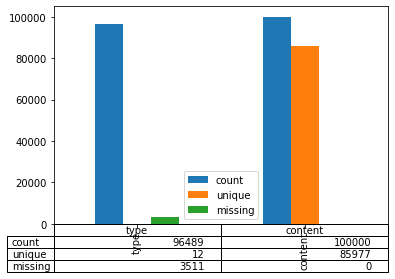

In [102]:
# Read csv-file
filepath = '../Data_git_ignore/ml_dataset.csv'
# filepath = '../Data_git_ignore/clean-100k.csv'
df = pd.read_csv(filepath, index_col = [0])

df = df[['type', 'content']]


# Calculating number: count, unique for each column
describe_df = df.describe(include=[np.object]).head(2)

# Calculating number: NaN for each column
nan_df = df.isna().sum()

# Create one df
describe_df.loc['missing'] = nan_df
# plot
describe_df.T.plot(kind='bar',  table=True)
describe_df # just display numbers
df.head(10)

In [115]:
# max size for whole dataset(train, test, validate)
max_size = 30000
# traning_set ratio - splits data into traning=ratio,  test and validate=(1-ratio)/2 ex. train=80%, test=10%, validate=10%
ratio=0.7
# Labels to include - ['fake', 'satire', 'bias', 'conspiracy', 'state', 'junksci', 'hate', 'clickbait', 'unreliable', 'political', 'reliable'] - all labels
use_types = ['fake', 'satire', 'bias', 'conspiracy', 'junksci', 'hate', 'clickbait', 'unreliable', 'political', 'reliable']
# Random seed
rnd = 1

### LATER USE ###
# possible_types = set(df['type'].unique())
# size = 9223372036854775807

# for t in use_type:
#     if t in possible_types:
#         if df['type'].value_counts().min() > max_size:
#             size = max_size
#         else:
#             size = df['type'].value_counts().min()
### USE THIS PT ###
if df['type'].value_counts().min() > max_size:
    size = max_size
else:
    # (min size of type) x (num of use_types)
    size = df['type'].value_counts().min()*len(use_types)


# initialize dataframes
train    = pd.DataFrame(columns = df.columns)
test     = pd.DataFrame(columns = df.columns)
validate = pd.DataFrame(columns = df.columns)

# add type to test splits
for t in use_types:
    # Create tmp_dataframe with sample of only t type
    tmp = df.loc[df['type'] == t].sample(n = int(size/len(use_types)), random_state=rnd)
    # split current type
    train_tmp, test_tmp, validate_tmp = np.split(tmp, [int(ratio * len(tmp)), int(((1-ratio)/2 + ratio) * len(tmp))])
    # add tmp to dataframes
    train    = pd.concat([train, train_tmp])
    test     = pd.concat([test, test_tmp])
    validate = pd.concat([validate, validate_tmp])
    
    # print split shape
    print("=>", t, tmp.shape, train_tmp.shape, validate_tmp.shape, validate_tmp.shape)

print("\n[Final split]\ntrain, test, validate ==>", train.shape, test.shape, validate.shape)

=> fake (124, 2) (86, 2) (19, 2) (19, 2)
=> satire (124, 2) (86, 2) (19, 2) (19, 2)
=> bias (124, 2) (86, 2) (19, 2) (19, 2)
=> conspiracy (124, 2) (86, 2) (19, 2) (19, 2)
=> junksci (124, 2) (86, 2) (19, 2) (19, 2)
=> hate (124, 2) (86, 2) (19, 2) (19, 2)
=> clickbait (124, 2) (86, 2) (19, 2) (19, 2)
=> unreliable (124, 2) (86, 2) (19, 2) (19, 2)
=> political (124, 2) (86, 2) (19, 2) (19, 2)
=> reliable (124, 2) (86, 2) (19, 2) (19, 2)

[Final split]
train, test, validate ==> (860, 2) (190, 2) (190, 2)


In [109]:
df['type'].value_counts()

fake          45768
political     27371
bias           9123
conspiracy     6877
junksci        2204
clickbait      1979
unknown        1067
unreliable     1045
satire          344
hate            298
reliable        289
rumor           124
Name: type, dtype: int64

In [106]:
# Split into labels and data
X_train    = train['content']
y_train    = train['type']
X_test     = test['content']
y_test     = test['type']
X_validate = validate['content']
y_validate = validate['type']

In [124]:
# Setup scikit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, log_loss
from sklearn.pipeline import Pipeline

# models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier


# Naive Bayes
clf_NB = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('NB', MultinomialNB()),])
                   
# Support vector machine
clf_svm = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('svm', SGDClassifier()),])

clf_svm.fit(X_train, y_train)
y_pred = clf_svm.predict(X_train)
f1_score(y_train , y_pred, zero_division=1)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [120]:
# All classifier-pipelines and their names
classifiers = [(clf_NB, 'Naive Bayes'), (clf_svm, 'Support vector machine')]

# Test multiple classifiers
for clf_tuple in classifiers:
    clf = clf_tuple[0]
    clf_name = clf_tuple[1]
    
    # Train model
    clf.fit(X_train, y_train)
    
    print("="*30)
    print(clf_name)
    
    print('****Results****')
    train_predictions = clf.predict(X_train)
    train_acc = f1_score(y_train, train_predictions)
    print("Train - Accuracy: {:.4%}".format(train_acc))
    
    test_predictions = clf.predict(X_test)
    test_acc = f1_score(y_test, test_predictions)
    print("Test  - Accuracy: {:.4%}".format(test_acc))
    
print("="*30)

Naive Bayes
****Results****


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [119]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# All classifiers to test
classifiers = [
    MultinomialNB()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train_tfidf, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_train)
    acc = f1_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

ValueError: Found input variables with inconsistent numbers of samples: [700, 860]

In [21]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

0.8733333333333333

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()


X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape


from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()


X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(700, 28555)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()


X_train_counts = count_vect.fit_transform(train.data)
X_train_counts.shape

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [86]:
reg_log = LogisticRegression()
reg_log.fit(X_train_tfidf, y_train)
y_pred = reg_log.predict(X_test_tfidf)

ValueError: X has 11943 features per sample; expecting 28555

In [81]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [150, 700]

In [74]:
print(test.iloc[0])

type                                                    fake
content    trump deeply saddened by shooting tragedy   of...
Name: 9, dtype: object


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [48]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

NameError: name 'category_to_id' is not defined

In [ ]:
# Create test split

In [95]:
# spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm')

In [96]:
import spacy

# Create an empty model
nlp = spacy.blank("en")

# Create the TextCategorizer with exclusive classes and "bow" architecture
textcat = nlp.create_pipe(
              "textcat",
              config={
                "exclusive_classes": True,
                "architecture": "bow"})

# Add the TextCategorizer to the empty model
nlp.add_pipe(textcat)

In [97]:
textcat.add_label("reliable")
textcat.add_label("fake")

1

In [98]:
train_texts = spam['content'].values
train_labels = [{'cats': {'reliable': label == 'reliable',
                          'fake': label == 'fake'}} 
                for label in spam['type']]

In [99]:
train_data = list(zip(train_texts, train_labels))
train_data[:3]

[('how to easily understand the difference between the day of christ and the day of lord in the end times',
  {'cats': {'reliable': False, 'fake': True}}),
 ('butter chocolate cheese cake   of readers think this story is fact add your two cents  headline bitcoin  blockchain searches exceed trump blockchain stocks are next  everybody is baking this cake on facebook and those who tried highly recommends so i am in for the fun and it is indeed a nice cake which is not difficult and requires any difficult to find ingredients    recipe adapted and modified from enne tay member of bakings corner fb and victoria bakes  ingredient a   NUM  NUM g butter soften i used  NUM g   NUM g caster sugar  NUM g for chocolate cake  4 large eggs5 small eggs  1 tsp vanilla essence   NUM g self rising flour sifted replace 4 tbsp of flour with cocoa powder for chocolate flavour this works out to be about  NUM g flour   NUM g cocoa powder for me  5 tbsp milkwhipping cream i used milk  ingredient b   NUM g crea

In [100]:
from spacy.util import minibatch

spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

# Create the batch generator with batch size = 8
batches = minibatch(train_data, size=8)
# Iterate through minibatches
for batch in batches:
    # Each batch is a list of (text, label) but we need to
    # send separate lists for texts and labels to update().
    # This is a quick way to split a list of tuples into lists
    texts, labels = zip(*batch)
    nlp.update(texts, labels, sgd=optimizer)

In [101]:
import random

random.seed(1)
spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()

losses = {}
for epoch in range(10):
    random.shuffle(train_data)
    # Create the batch generator with batch size = 8
    batches = minibatch(train_data, size=8)
    # Iterate through minibatches
    for batch in batches:
        # Each batch is a list of (text, label) but we need to
        # send separate lists for texts and labels to update().
        # This is a quick way to split a list of tuples into lists
        texts, labels = zip(*batch)
        nlp.update(texts, labels, sgd=optimizer, losses=losses)
    print(losses)

{'textcat': 0.42940836820412187}
{'textcat': 0.4644174363059138}
{'textcat': 0.4771925903408549}
{'textcat': 0.4817915157846454}
{'textcat': 0.48784991711729686}
{'textcat': 0.48926299730876416}
{'textcat': 0.49029758039908317}
{'textcat': 0.49099400026056245}
{'textcat': 0.4914884020242378}
{'textcat': 0.4918252931571014}


In [45]:


texts = ["Are you ready for the tea party????? It's gonna be wild",
         "URGENT Reply to this message for GUARANTEED FREE TEA" ]
docs = [nlp.tokenizer(text) for text in texts]
    
# Use textcat to get the scores for each doc
textcat = nlp.get_pipe('textcat')
scores, _ = textcat.predict(docs)

print(scores)



[[0.57025945 0.42974052]
 [0.46458614 0.53541386]]


# word vectors

In [102]:
import numpy as np
import spacy

# Need to load the large model to get the vectors
nlp = spacy.load('en_core_web_lg')

In [103]:
# Disabling other pipes because we don't need them and it'll speed up this part a bit
text = "These vectors can be used as features for machine learning models."
with nlp.disable_pipes():
    vectors = np.array([token.vector for token in  nlp(text)])

In [104]:
vectors.shape

(12, 300)

In [108]:
import pandas as pd

# Loading the spam data
# ham is the label for non-spam messages

with nlp.disable_pipes():
    doc_vectors = np.array([nlp(text).vector for text in spam.content])
    
doc_vectors.shape

(1000, 300)

In [46]:
# From the scores, find the label with the highest score/probability
predicted_labels = scores.argmax(axis=1)
print([textcat.labels[label] for label in predicted_labels])

['reliable', 'fake']


In [110]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_vectors, spam.type,
                                                    test_size=0.1, random_state=1)

In [111]:
from sklearn.svm import LinearSVC

# Set dual=False to speed up training, and it's not needed
svc = LinearSVC(random_state=1, dual=False, max_iter=10000)
svc.fit(X_train, y_train)
print(f"Accuracy: {svc.score(X_test, y_test) * 100:.3f}%", )

Accuracy: 89.000%


In [113]:


def cosine_similarity(a, b):
    return a.dot(b)/np.sqrt(a.dot(a) * b.dot(b))


a = nlp("REPLY NOW FOR FREE TEA").vector
b = nlp("According to legend, Emperor Shen Nung discovered tea when leaves from a wild tree blew into his pot of boiling water.").vector
cosine_similarity(a, b)

0.70300317

In [12]:
connection = psycopg2.connect(user = "postgres",
                                      password = "root",
                                      host = "localhost",
                                      port = "5432",
                                      database = "postgres")

# usage: specify file location, sample size and seed(used by random)
filepath = 'train.tsv'
filepathTest = 'test.tsv'

#filepath = 'news_sample.csv' # <- overwrite for setup
s = 200                    # desired sample size(seems to have slack ie. not exact)
stest = 200                    # desired sample size(seems to have slack ie. not exact)

seed = 1                     # seed used by Pseudorandom number generator

df_train = pd.read_csv(filepath, header = 0, sep='\t').sample(n=s, random_state=seed)
df_train["content"] = df_train["content"].astype(str)

df_test = pd.read_csv(filepathTest, header=0, sep='\t').sample(n=stest, random_state=seed)
df_train["content"] = df_train["content"].astype(str)

df_test = df_test.reset_index(drop=True)
df_test = df_train.reset_index(drop=True)

# df = pd.read_sql_query("""Select content, type_id
# from article""", connection)

FileNotFoundError: [Errno 2] File train.tsv does not exist: 'train.tsv'

In [ ]:
a = nlp("REPLY NOW FOR FREE TEA").vector
b = nlp("According to legend, Emperor Shen Nung discovered tea when leaves from a wild tree blew into his pot of boiling water.").vector
cosine_similarity(a, b)

In [13]:
df_test.head()

NameError: name 'df_test' is not defined

In [14]:
# VIGTIG NOTE: måden jeg opdeler sættet på er MEGET dårlig, på det endelige skal vi shuffle og derefter opdele! 

In [15]:
### Nearest hood (neighbors)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(df["content"])

In [ ]:
from sklearn.neighbors import NearestCentroid

X = np.array(x.toarray()[int(len(df["type_id"])/2):])
y = np.array(df["type_id"][int(len(df["type_id"])/2):])
clf = NearestCentroid()
clf.fit(X, y)

In [19]:
test_X = x.toarray()[:int(len(df["type_id"])/2)]
test_y = df["type_id"][:int(len(df["type_id"])/2)]

predictions = clf.predict(np.array(test_X))

failCounter = 0
for i in range(int(len(df["type_id"])/2)):
    if (predictions[i] != test_y[i]):
        failCounter += 1
        
print("Number of mislabeled points out of a total %d points : %d" % (len(test_X), failCounter))

MemoryError: Unable to allocate 454. GiB for an array with shape (130530, 466973) and data type float64

In [20]:
### Naive bayes

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(x.toarray(), df["type_id"], test_size=0.5, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

MemoryError: Unable to allocate 454. GiB for an array with shape (130530, 466973) and data type float64

In [22]:
### Decision trees

In [23]:
from sklearn import tree

X = x.toarray()[int(len(df["type_id"])/2):]
y = df["type_id"][int(len(df["type_id"])/2):]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_X, train_y)

MemoryError: Unable to allocate 454. GiB for an array with shape (130530, 466973) and data type float64

In [24]:
test_X = x.toarray()[:int(len(df["type_id"])/2)]
test_y = df["type_id"][:int(len(df["type_id"])/2)]

predictions = clf.predict(np.array(train_X))

failCounter = 0
for i in range(int(len(df["type_id"])/2)):
    if (predictions[i] != test_y[i]):
        failCounter += 1
        
print("Number of mislabeled points out of a total %d points : %d" % (len(test_X), failCounter))

MemoryError: Unable to allocate 454. GiB for an array with shape (130530, 466973) and data type float64

In [25]:
### Support Vector Machines

In [26]:
from sklearn import svm
X = x.toarray()[int(len(df["type_id"])/2):]
y = df["type_id"][int(len(df["type_id"])/2):]
clf = svm.SVC(gamma='scale')
clf.fit(X, y)

MemoryError: Unable to allocate 454. GiB for an array with shape (130530, 466973) and data type float64

In [27]:
### note testen gik meget godt, men det betyder ikke man har en god model ;)
clf.predict(np.array(train_X))

NameError: name 'clf' is not defined

In [28]:
test_X = x.toarray()[:int(len(df["type_id"])/2)]
test_y = df["type_id"][:int(len(df["type_id"])/2)]

predictions = clf.predict(np.array(train_X))

failCounter = 0
for i in range(int(len(df["type_id"])/2)):
    if (predictions[i] != test_y[i]):
        failCounter += 1
        
print("Number of mislabeled points out of a total %d points : %d" % (len(test_X), failCounter))

MemoryError: Unable to allocate 454. GiB for an array with shape (130530, 466973) and data type float64

In [29]:
# Med Lair datasæt

In [30]:
### nearest hood

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x.toarray(), df_train["rating"], test_size=0.5, random_state=0)

MemoryError: Unable to allocate 454. GiB for an array with shape (130530, 466973) and data type float64

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(df_train["content"])

NameError: name 'df_train' is not defined

In [76]:
from sklearn.neighbors import NearestCentroid

clf = NearestCentroid()
clf.fit(X_train, y_train)

ValueError: could not convert string to float: 'how to easily understand the difference between the day of christ and the day of lord in the end times'

In [34]:
### Naive bias

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

NameError: name 'X_train' is not defined

In [36]:
### Decision trees

In [37]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [38]:
### Support Vector Machine

In [39]:
from sklearn import svm

clf = svm.SVC(gamma='scale')
clf.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [40]:
### test model

In [41]:
predictions = clf.predict(np.array(test_X))

failCounter = 0
for i in range(int(len(df_test["rating"])/2)):
    if (predictions[i] != test_y[i]):
        failCounter += 1
        
print("Number of mislabeled points out of a total %d points : %d" % (len(test_X), failCounter))

NameError: name 'test_X' is not defined

In [42]:
from sklearn.metrics import f1_score

f1_score(y_test, predictions, average='macro')

NameError: name 'y_test' is not defined